In [32]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from typing import Literal, Callable
from sklearn import manifold
from scipy.spatial import distance_matrix

In [33]:
import utils

In [34]:
def affinity_matrix(W, n_neighbors=20, alpha=1.0):
    nn_max = np.mean(np.sort(W)[:, n_neighbors + 1])
    eps = 2 * nn_max ** 2

    # Kernel matrix
    K = np.exp(-(W ** 2) / eps)
    # alpha_norm = K.sum(axis=1) ** alpha
    # K /= alpha_norm
    # K /= alpha_norm[:, None]
    return K

In [35]:
def l1_cmp(W1, W2, n_neighbors):
    W1_normed = W1 / np.linalg.norm(W1, ord=1)
    W2_normed = W2 / np.linalg.norm(W2, ord=1)
    res = np.linalg.norm(W1_normed - W2_normed, ord=1)
    return res

In [36]:
def f_cmp(W1, W2, n_neighbors):
    W1_normed = W1 / np.linalg.norm(W1)
    W2_normed = W2 / np.linalg.norm(W2)
    res = np.linalg.norm(W1_normed - W2_normed)
    return res

In [37]:
def nn_cmp(W1, W2, n_neighbors):
    l1 = np.argsort(W1, axis=1)[:, :n_neighbors + 1]
    l2 = np.argsort(W2, axis=1)[:, :n_neighbors + 1]
    res = 0
    for x, y in zip(l1, l2):
        res += len(set(x).symmetric_difference(set(y)))
    return res

In [38]:
def ranked_nn_cmp(W1, W2, n_neighbors):
    delta = np.argsort(np.argsort(W1, axis=1), axis=1) - np.argsort(np.argsort(W2, axis=1), axis=1)
    res = np.sum(np.abs(delta[:, :n_neighbors + 1]))
    return res

In [39]:
def process_spectral(data, cmp: Callable[[np.ndarray, np.ndarray, int], float],
            n_neighbors: int = 100, n_components_tried: int = 20):
    W = utils.gen_dist_matrix(data)
    scores = []
    aff_matrix = affinity_matrix(W, n_neighbors=n_neighbors)
    for n_components in range(1, n_components_tried + 1):
        model = manifold.SpectralEmbedding(n_components=n_components, affinity="precomputed")
        embedding = model.fit_transform(aff_matrix)
        W_embedded = distance_matrix(embedding, embedding)
        score = cmp(W, W_embedded, n_neighbors)
        scores.append(score)
    return scores

In [40]:
def process_spectral_sorted(data, cmp: Callable[[np.ndarray, np.ndarray, int], float],
            n_neighbors: int = 100, n_components_tried: int = 20):
    W = utils.gen_dist_matrix(data)
    heuristic_scores, complete_embedding, _ = utils.spectral_embedding(W, n_neighbors, do_plot=False, n_components=n_components_tried)
    complete_embedding = complete_embedding[:,np.argsort(heuristic_scores)[::-1]]

    scores = []
    for n_components in range(1, n_components_tried + 1):
        embedding = complete_embedding[:,:n_components]
        W_embedded = distance_matrix(embedding, embedding)
        score = cmp(W, W_embedded, n_neighbors)
        scores.append(score)
    return scores

In [41]:
def full_run(experiment_name: str, expected_embed_size: int, process, n_neighbors: int = 100, n_components: int = 20):
    comps_range = range(1, n_components + 1)
    data = utils.get_data(experiment_name)

    # L1
    scores = process(data, l1_cmp, n_neighbors, n_components_tried=n_components)
    plt.figure()
    plt.scatter(comps_range, scores)
    plt.title(f"L1. {experiment_name}. Expected embed size: {expected_embed_size}")
    plt.xlabel("Number of conserved quantities")
    plt.ylabel("L1 norm diff of distance matrices ")
    plt.xticks(comps_range)

    # Neighbors
    scores = process(data, nn_cmp, n_neighbors, n_components_tried=n_components)
    plt.figure()
    plt.scatter(comps_range, scores)
    plt.title(f"Neighbors. {experiment_name}. Expected embed size: {expected_embed_size}")
    plt.xlabel("Number of conserved quantities")
    plt.ylabel("Set symmetric difference of nearest neighbors")
    plt.xticks(comps_range)

    # Ranked neighbors
    scores = process(data, ranked_nn_cmp, n_neighbors, n_components_tried=n_components)
    plt.figure()
    plt.scatter(comps_range, scores)
    plt.title(f"Ranks. {experiment_name}. Expected embed size: {expected_embed_size}")
    plt.xlabel("Number of conserved quantities")
    plt.ylabel("Rank difference of nearest neighbors")
    plt.xticks(comps_range)

    # Frobenius norm
    scores = process(data, f_cmp, n_neighbors, n_components_tried=n_components)
    plt.figure()
    plt.scatter(comps_range, scores)
    plt.title(f"F norm. {experiment_name}. Expected embed size: {expected_embed_size}")
    plt.xlabel("Number of conserved quantities")
    plt.ylabel("F norm diff of distance matrices ")
    plt.xticks(comps_range)

## Results

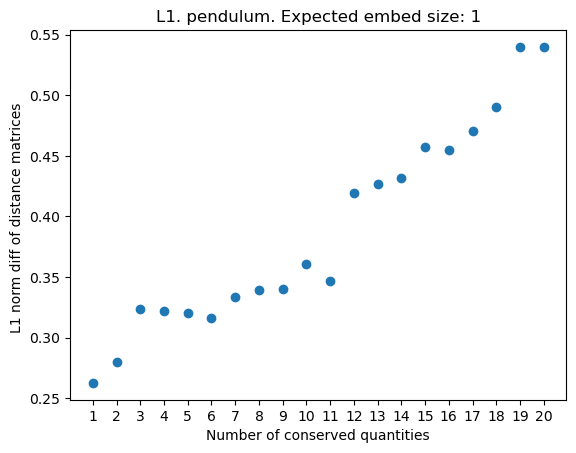

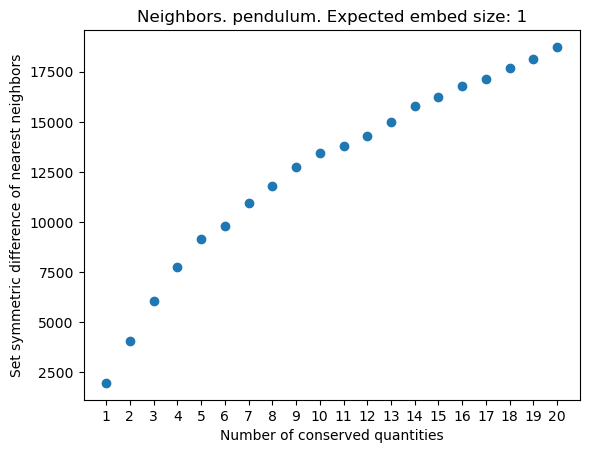

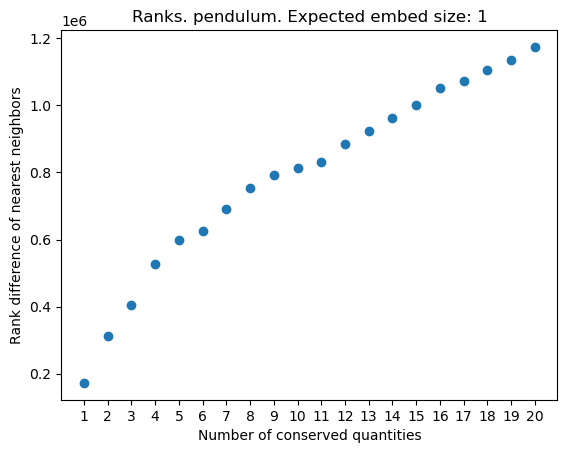

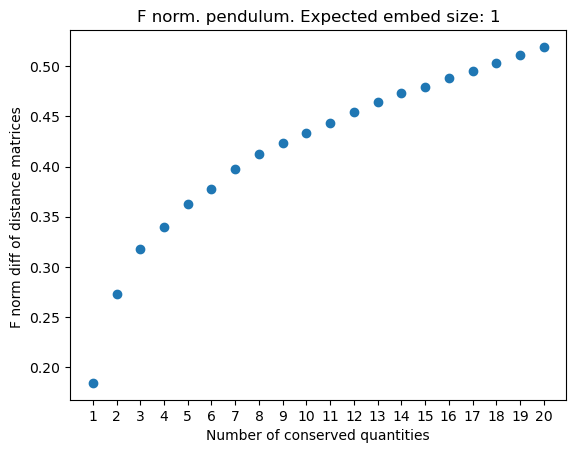

In [42]:
full_run("pendulum", 1, process_spectral)

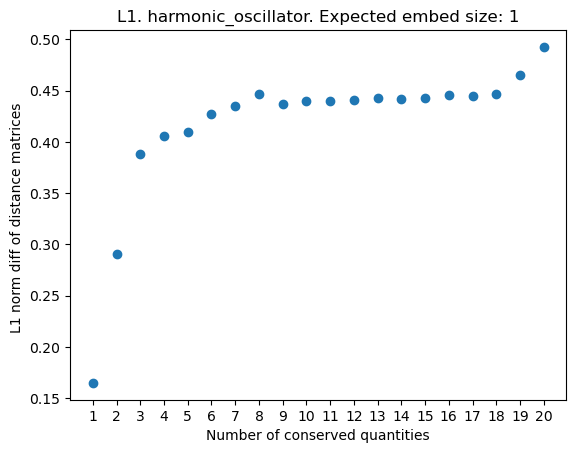

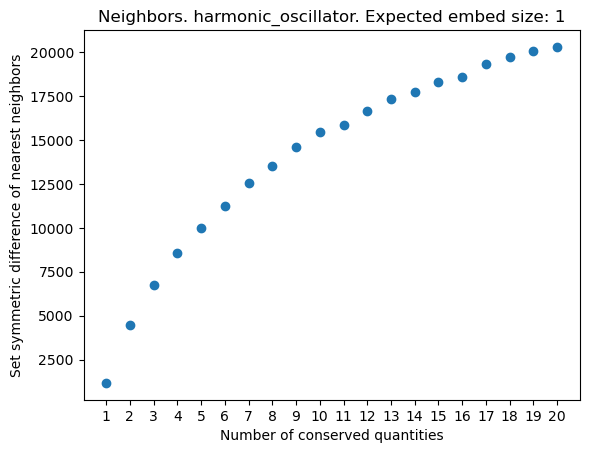

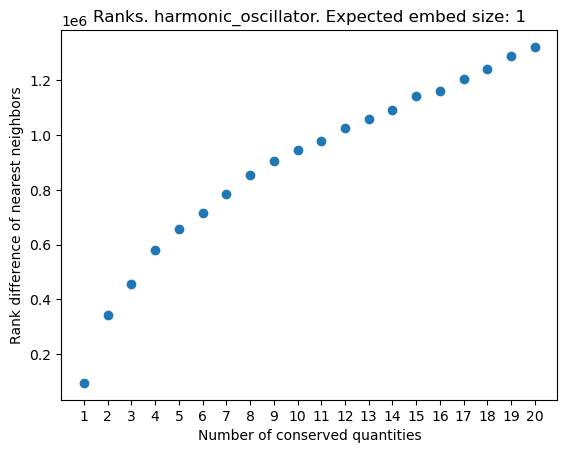

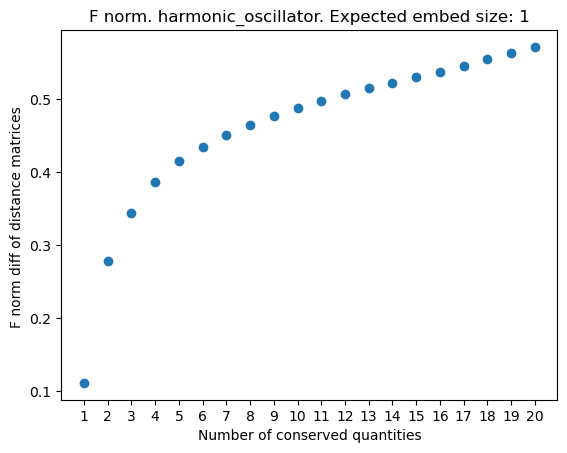

In [43]:
full_run("harmonic_oscillator", 1, process_spectral)

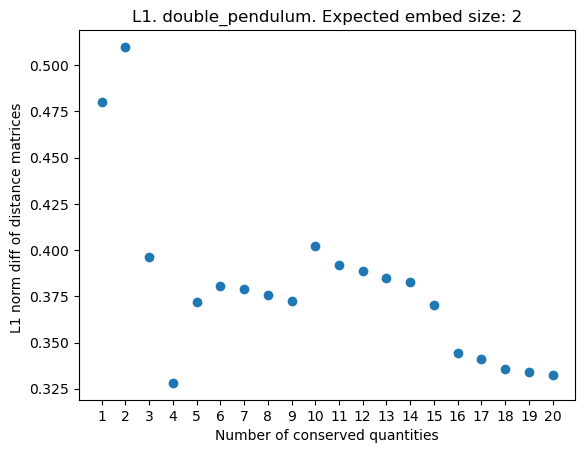

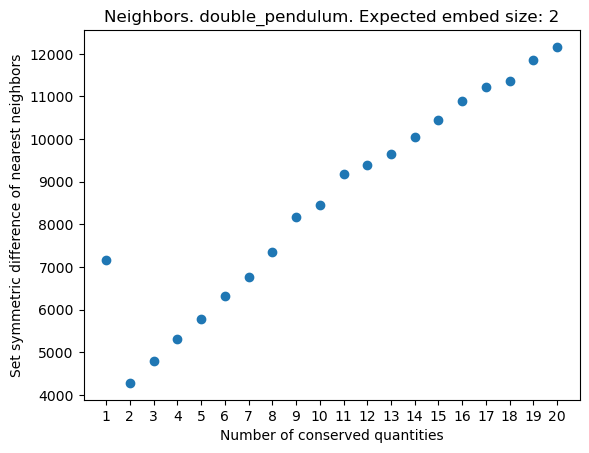

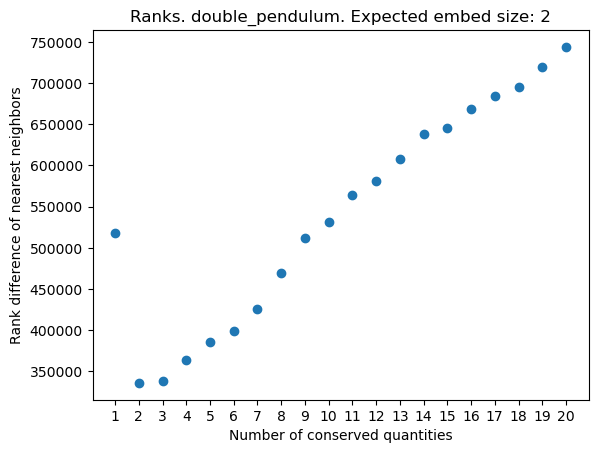

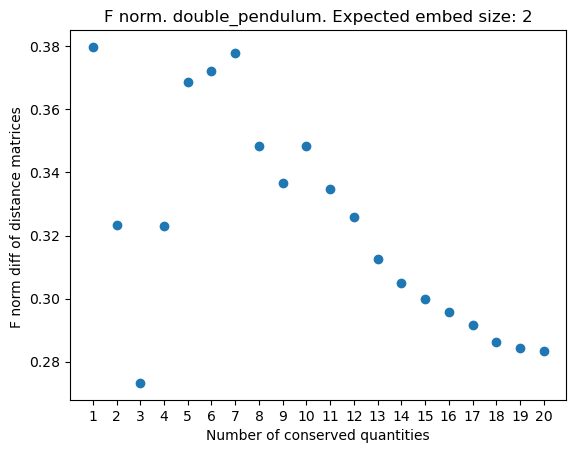

In [44]:
full_run("double_pendulum", 2, process_spectral, n_neighbors=50)

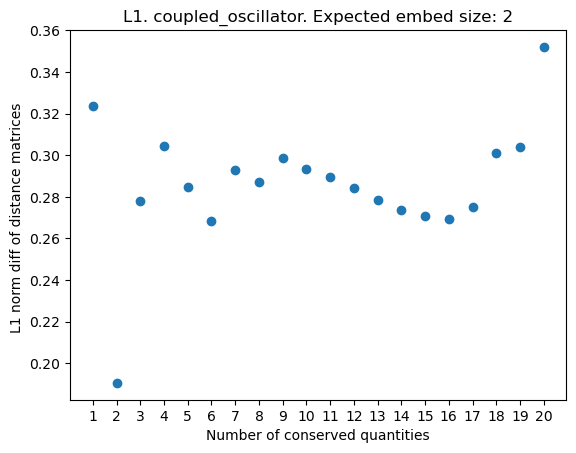

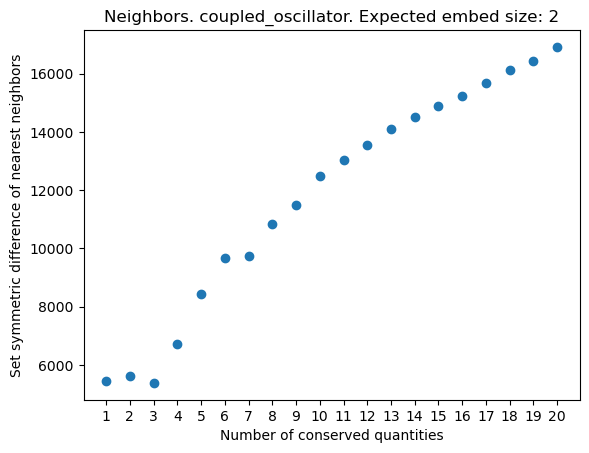

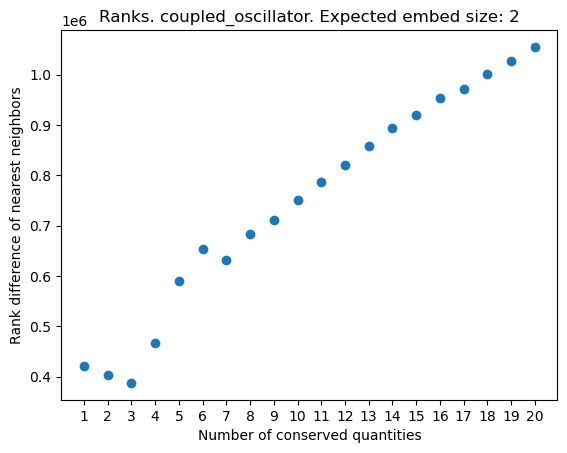

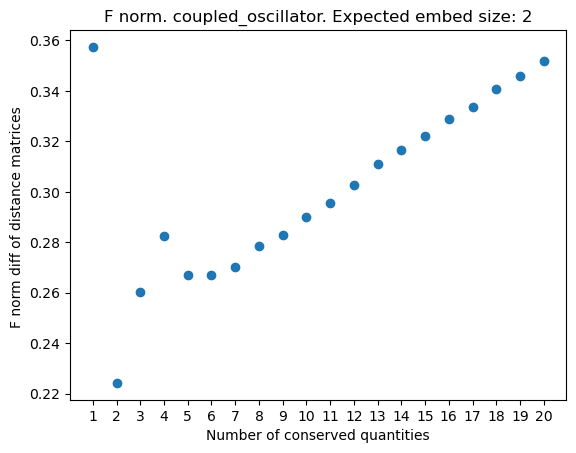

In [45]:
full_run("coupled_oscillator", 2, process_spectral)

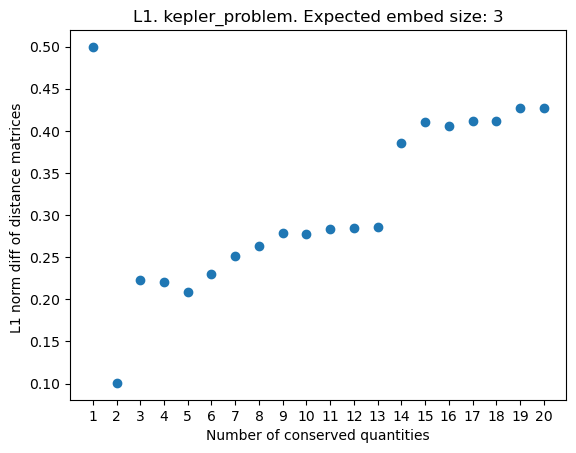

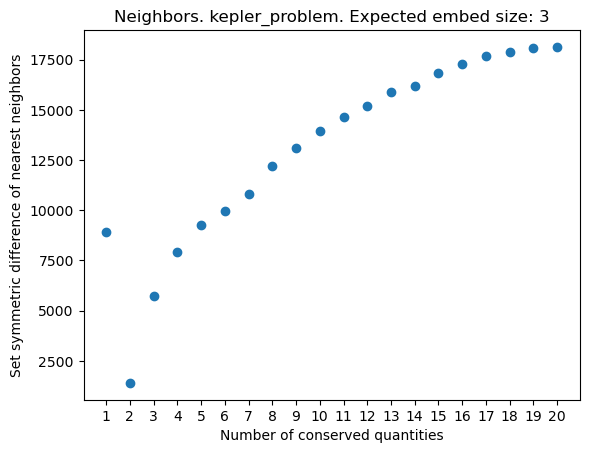

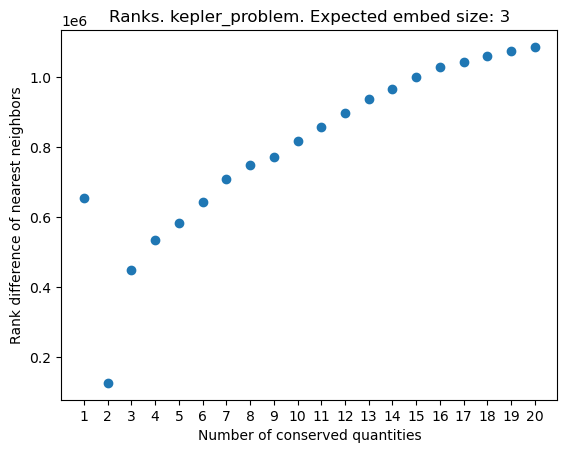

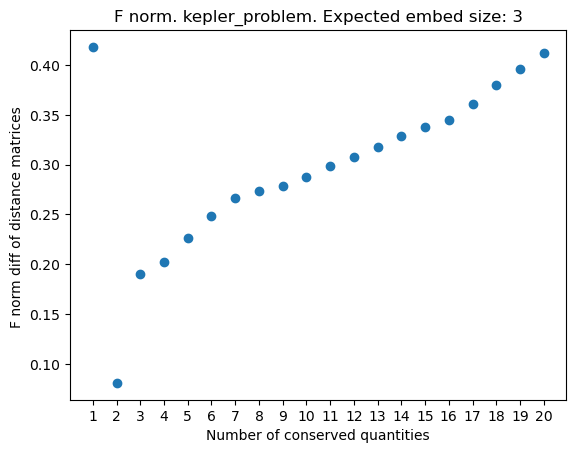

In [46]:
full_run("kepler_problem", 3, process_spectral)

### Using Soljacic Spectral Embedding and sorted by heuristic score

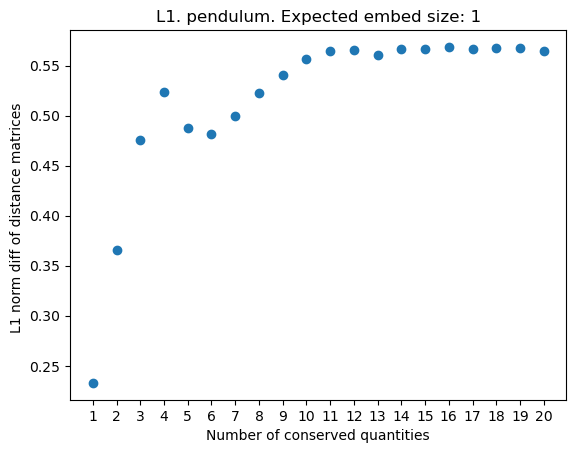

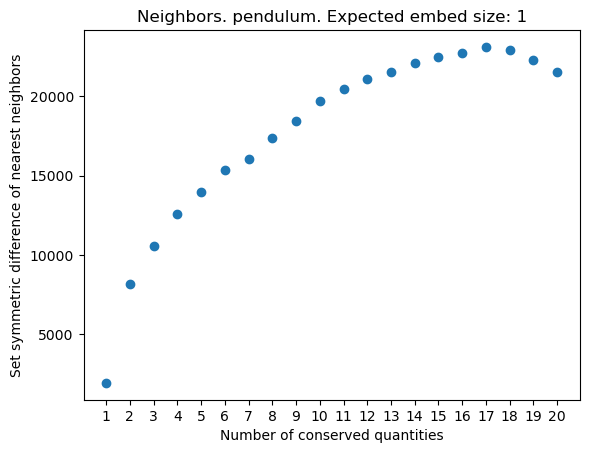

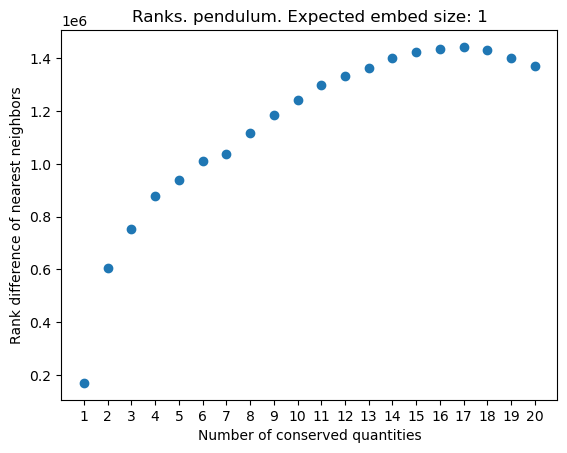

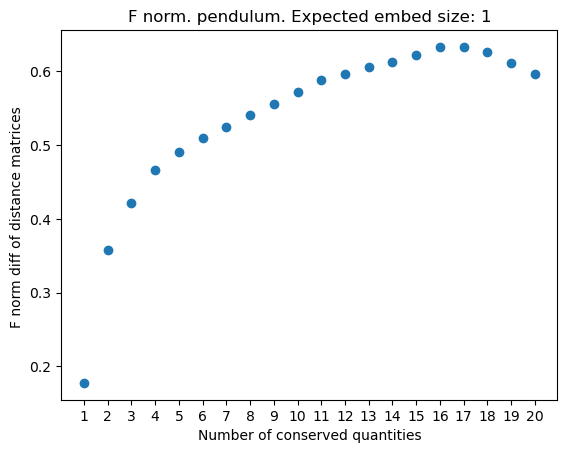

In [47]:
full_run("pendulum", 1, process_spectral_sorted)

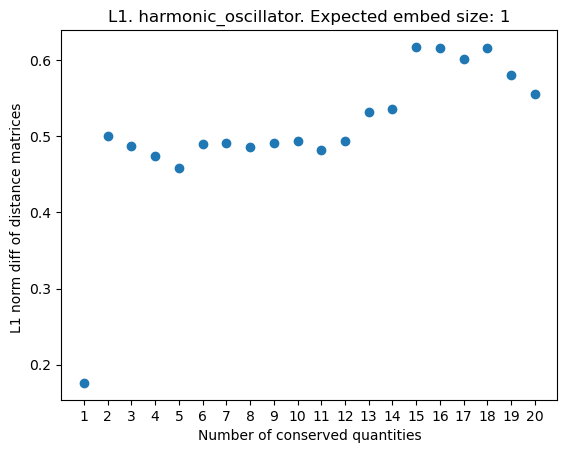

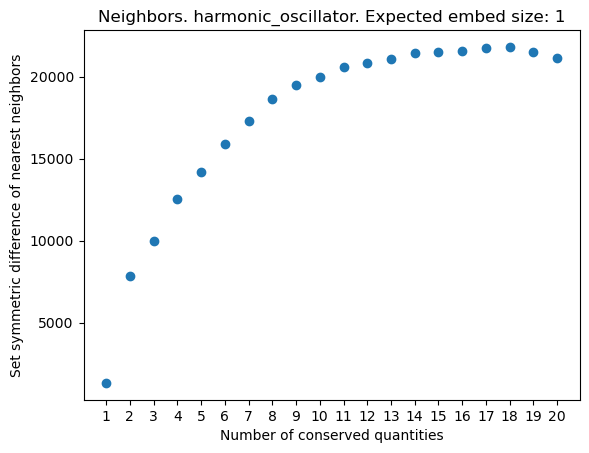

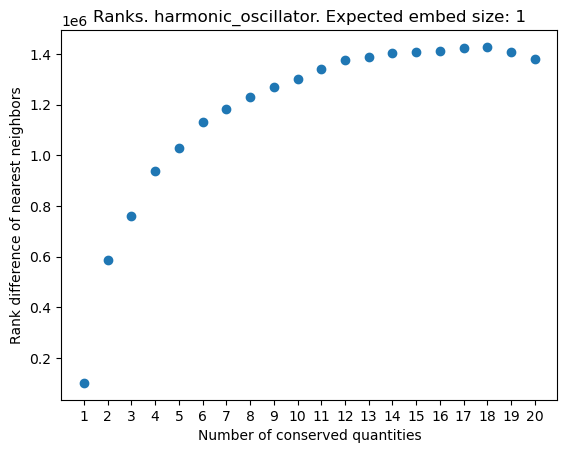

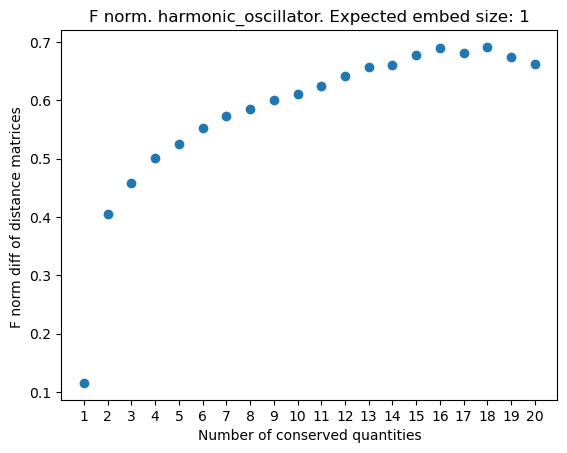

In [48]:
full_run("harmonic_oscillator", 1, process_spectral_sorted)

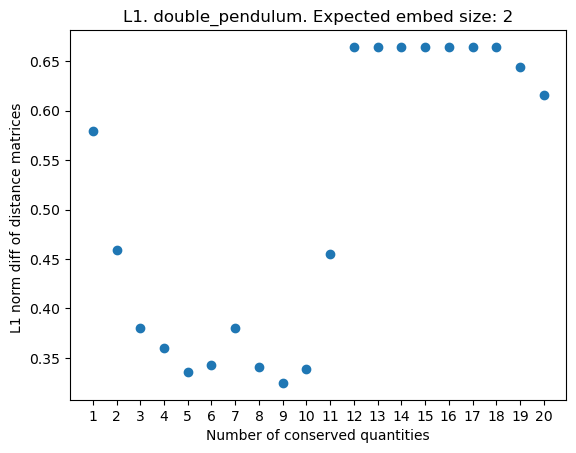

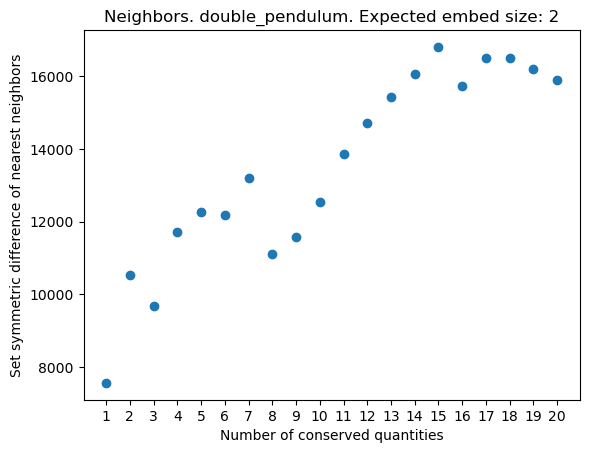

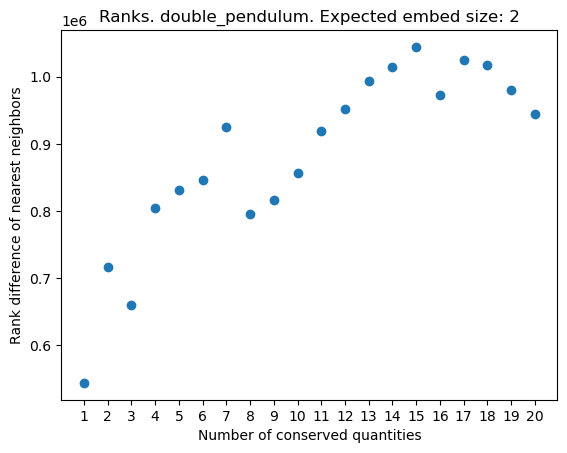

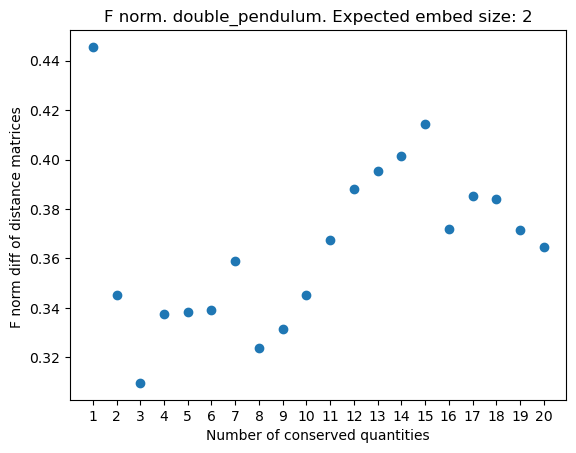

In [49]:
full_run("double_pendulum", 2, process_spectral_sorted)

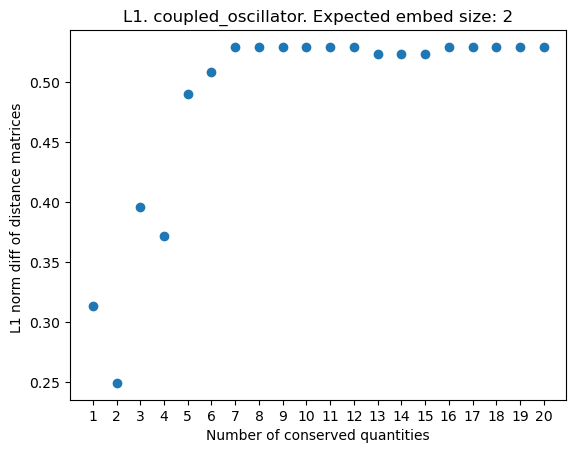

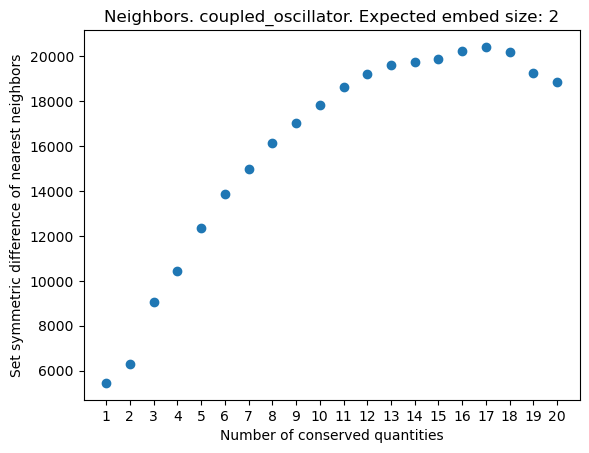

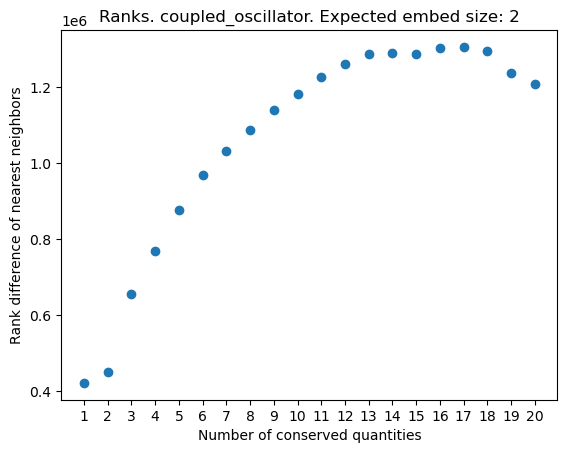

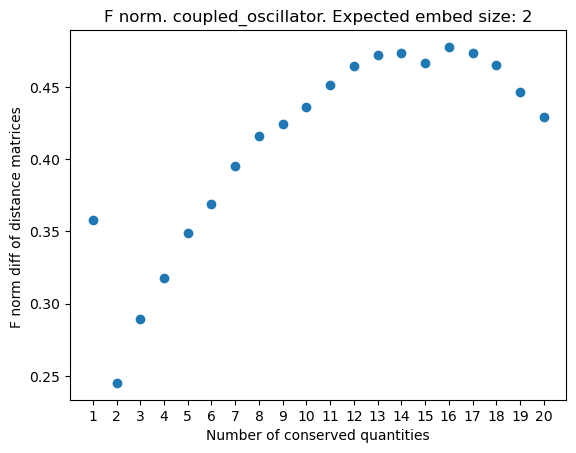

In [50]:
full_run("coupled_oscillator", 2, process_spectral_sorted)

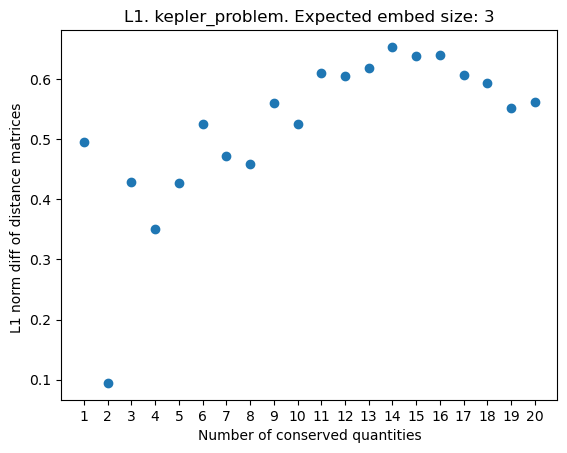

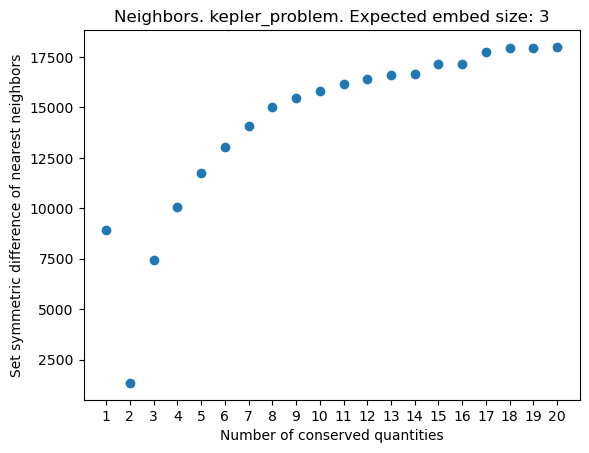

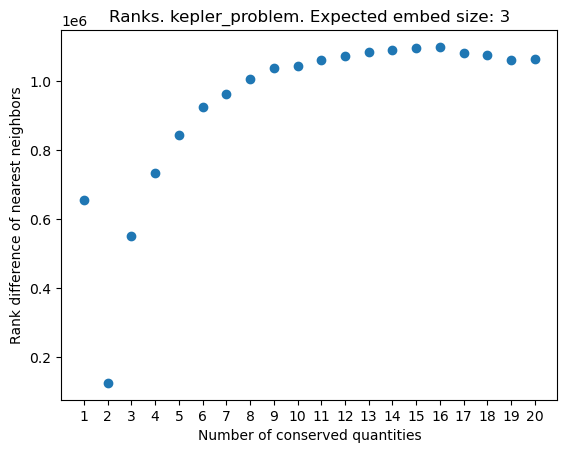

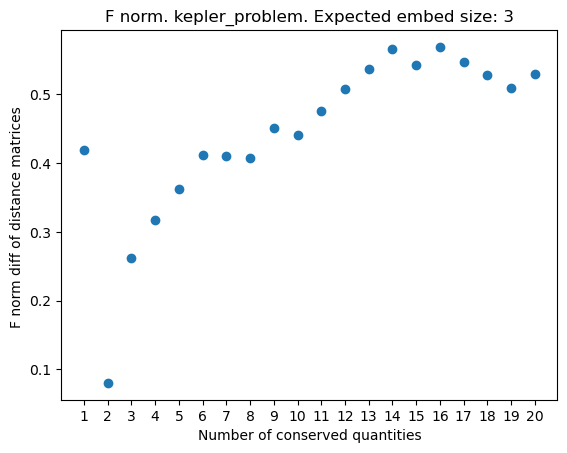

In [51]:
full_run("kepler_problem", 3, process_spectral_sorted)